## Import Packages

In [1]:
import os
import gc
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time 
from functools import partial
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModel, AutoConfig
from tokenizers import AddedToken
from datasets import Dataset as HF_Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from scipy.special import softmax

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.2.0
CUDA Available: True
CUDA Version: 12.1


In [2]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

In [3]:
# Global Var

platform = '.' # '/kaggle' or '.'

TRAIN_CSV = f'{platform}/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
MODEL_DIR = f'{platform}/input/huggingfacedebertav3variants'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [4]:
from typing import Any

class TrainerConfig:
    def __init__(self):
        self.weight_decay = 0.01
        self.max_lr = 1e-5
        self.epochs = 10
        self.lr_final_div = 10
        self.amp = True
        self.grad_accum_steps = 1
        self.max_grad_norm = 1e7
        self.print_freq = 500
    
    def __setattr__(self, name: str, value: Any) -> None:
        self.__dict__[name] = value

trainer_config = TrainerConfig()

class CONFIG:
    MODEL_NAME = "DeBerta_base_Max_1024_Persuade_Regression"
    OUTPUT_DIR = f"{platform}/working"
    N_CLASSES = 1
    MAX_LENGTH = 1024
    EMBEDDING_SIZE = 768
    DEBERTA_PATH = f"{MODEL_DIR}/deberta-v3-base"
    USE_SCORE_WEIGHTS = np.array([1, 1, 1, 1, 1, 1])
    BATCH_SIZE = 8
    SEED = 2046
    NUM_WORKERS = 0
    TRAINER_CFG = TrainerConfig()

In [5]:
def seed_everything(seed):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# fix random seed
seed_everything(seed=CONFIG.SEED)

# Load Data

Load CSV, convert to tokens, and generate embedding.

In [7]:
train_csv = pd.read_csv(TRAIN_CSV, nrows=None)
train_csv['label'] = train_csv['score'] - 1
train_csv['text_length'] = train_csv['full_text'].apply(lambda x: len(x.split()))

print("train_csv shape = ", train_csv.shape)

persuade_csv = pd.read_csv('./input/train_persuade.csv', nrows=None)
persuade_csv['label'] = persuade_csv['score'] - 1

print("persuade_csv shape = ", persuade_csv.shape)

train_csv.sort_values('text_length', ascending=False).head()

train_csv shape =  (17307, 5)
persuade_csv shape =  (13125, 4)


,essay_id,full_text,score,label,text_length
2155,20cb752,I thought it might be boring and a lot of work...,2,1,1656
8609,7fe2d12,"To the state and the state's country, the elec...",6,5,1367
15824,e9831f4,When limiting car usage the first thing that m...,6,5,1351
2803,29daf40,As the global concern for the environment incr...,5,4,1312
5158,4d00492,"Dear Senator,\n\nConcerning the topic of the m...",6,5,1302


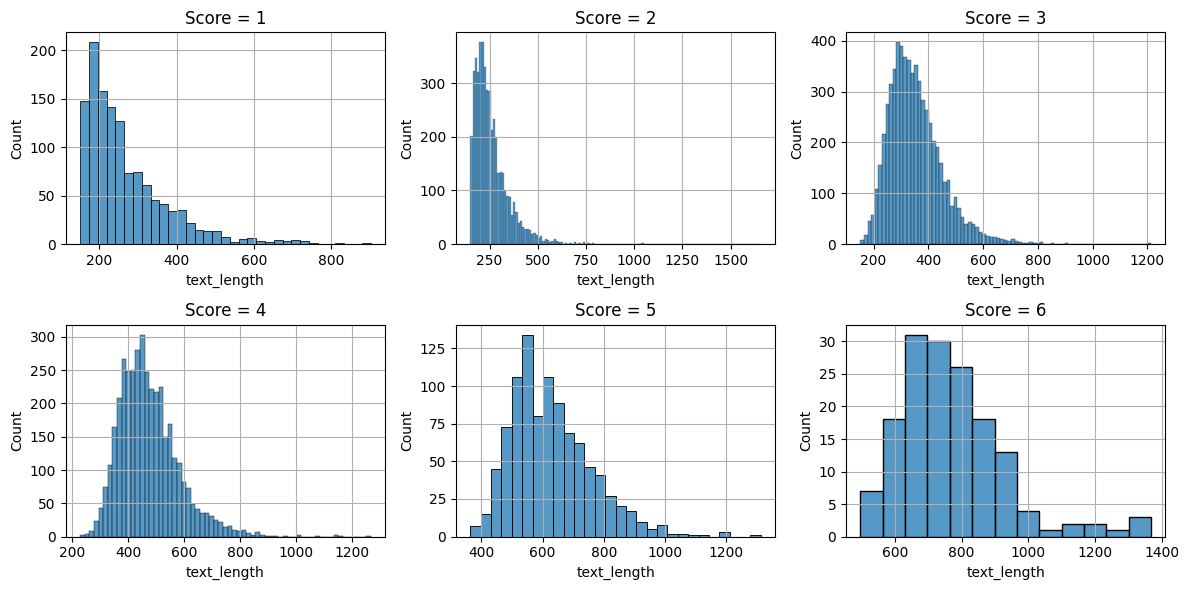

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    sns.histplot(train_csv[train_csv['score']==i+1]['text_length'], ax=ax, kde=False)
    ax.set_title(f"Score = {i+1}")
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In [9]:
embedding_tokenizer = AutoTokenizer.from_pretrained(CONFIG.DEBERTA_PATH, use_fast=False) 
embedding_tokenizer.add_tokens([AddedToken("\n", normalized=False)])
embedding_tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])

embedding_model = AutoModel.from_pretrained(CONFIG.DEBERTA_PATH)

In [10]:
def remove_extra_whitespace_tabs(text):
    cleaned_text = re.sub(r'(\s*[?]+|\xa0)\s*', ' ', text)
    cleaned_text = re.sub(r'^\s*|\s\s*', ' ', cleaned_text).strip()
    return cleaned_text

def tokenize_function(examples, tokenizer, max_length):
    
    tokenizer_kwargs = dict(
        padding='max_length', 
        truncation=True, 
        max_length=max_length,
        return_tensors = 'np',
        return_token_type_ids = False,
        return_attention_mask = True,
        return_length=False
    )
    
    clean_text = [remove_extra_whitespace_tabs(text) for text in examples['full_text']]
    tokens = tokenizer(clean_text, **tokenizer_kwargs)
    return tokens

def collate_fn(batch):
    
    input_ids = [np.array(x['input_ids']) for x in batch]
    attention_mask = [np.array(x['attention_mask']) for x in batch]
    
    labels = torch.tensor([float(x['label']) for x in batch]).unsqueeze(1)
    
    data_dict = {
        'input_ids': torch.tensor(np.vstack(input_ids), dtype=torch.int32),
        'attention_mask': torch.tensor(np.vstack(attention_mask), dtype=torch.int8),
        'label': labels
        }
    
    return data_dict

In [11]:
tokenize_fn = partial(
    tokenize_function, 
    tokenizer=embedding_tokenizer, 
    max_length=CONFIG.MAX_LENGTH
    )

train_ds = HF_Dataset.from_dict({
    'essay_id': train_csv['essay_id'].to_list(),
    'full_text': train_csv['full_text'].to_list(),
    'label': train_csv['label'].to_list()
    }).map(tokenize_fn, batched=True)

persuade_ds = HF_Dataset.from_dict({
    'essay_id': persuade_csv['essay_id'].to_list(),
    'full_text': persuade_csv['full_text'].to_list(),
    'label': persuade_csv['label'].to_list()
    }).map(tokenize_fn, batched=True)

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

In [ ]:
# # Test dataloader

# data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)
# for batch in data_loader:
#     data_dict = batch
    
#     print(data_dict['input_ids'].shape)
#     print(data_dict['attention_mask'].shape)
#     print(data_dict['label'].shape)
    
#     with torch.no_grad():
#         embeddings = embedding_model(
#             input_ids = data_dict['input_ids'],
#             attention_mask = data_dict['attention_mask']
#         )['last_hidden_state']
        
#     print(embeddings.shape)
    
#     break

# Model

In [12]:
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, batch_rep, attention_mask):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        return:
            utter_rep: size (N, H)
        """
        att_logits = self.W(batch_rep).squeeze(-1)
        att_logits.masked_fill_((attention_mask==0).squeeze(-1), float('-inf'))
        att_w = self.softmax(att_logits).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)
        return utter_rep


class DeBERTaClassifier(nn.Module):
    
    def __init__(self, embedding_model, embedding_dim, n_classes, n_mlp_layers=0, len_token=None):
        super(DeBERTaClassifier, self).__init__()
        
        self.n_mlp_layers = n_mlp_layers
        self.mlp_hidden_size = embedding_dim * (self.n_mlp_layers + 1)
        
        config = AutoConfig.from_pretrained(embedding_model)
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        
        self.berta = AutoModel.from_pretrained(embedding_model, config=config)
        if len_token:
            print("Resize token embeddings...")
            self.berta.resize_token_embeddings(len_token)
        
        # self.pooling = SelfAttentionPooling(hidden_size)
        
        self.mlp = nn.Sequential(
           nn.Linear(self.mlp_hidden_size, self.mlp_hidden_size//2),
           nn.GELU(),
           nn.Linear(self.mlp_hidden_size//2, n_classes)
        )
        
        # self.linear = nn.Linear(self.mlp_hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        
        # get embeddings from berta
        berta_outputs = self.berta(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )

        # Using CLS token for pooling
        # embeddings = berta_outputs['last_hidden_state'][:, 0, :]
        
        # pass pooling
        embeddings = berta_outputs['last_hidden_state']
        embeddings.masked_fill_((attention_mask==0).unsqueeze(-1), float("-inf"))
        embeddings = embeddings.permute(0, 2, 1)
        # pooled_hidden_state = self.pooling(embeddings)
        pooled_hidden_state = F.max_pool1d(embeddings, kernel_size=embeddings.size(-1)).squeeze(-1)
        
        logits = self.mlp(pooled_hidden_state)
        
        output = {
            'logits': logits,
            'hidden_state': embeddings
        }
        
        return output

In [ ]:
# # Test Model

# model = DeBERTaClassifier(
#         CONFIG.DEBERTA_PATH, 
#         embedding_dim=CONFIG.EMBEDDING_SIZE, 
#         n_classes=CONFIG.N_CLASSES,
#         n_mlp_layers=0, 
#         len_token=len(embedding_tokenizer)
#     )

# data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)

# # model.to(DEVICE)
# for data_dict in data_loader:
#     input_ids = data_dict['input_ids']#.to(DEVICE)
#     attention_mask = data_dict['attention_mask']#.to(DEVICE)
#     model_output = model(input_ids, attention_mask)
#     print("Model output logits shape: ", model_output['logits'].shape)
#     print("Model output hidden_state shape: ", model_output['hidden_state'].shape)
    
#     input_ids.detach().cpu() 
#     attention_mask.detach().cpu()
#     del input_ids, attention_mask
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     break

# Model Training

### Define Loss

In [13]:
class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, n_class, weights=None, order=2, epsilon=1e-13, device='cpu'):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.a = order
        self.epsilon = epsilon
        self.device = device

        d_matrix = (torch.arange(n_class, device=device).unsqueeze(0) - 
                    torch.arange(n_class, device=device).unsqueeze(1)).abs()
        
        if weights is not None:
            w_matrix = (torch.tensor(weights, device=device).unsqueeze(0) +
                        torch.tensor(weights, device=device).unsqueeze(1)).float()
            c_matrix = (d_matrix.float().pow(self.a) + 1) * w_matrix
        else:
            c_matrix = d_matrix.float().pow(self.a)
        
        self.register_buffer('C', c_matrix)
        
    def forward(self, y_pred, y_true):
        # select corresponding rows from D
        distances = torch.matmul(y_true.float(), self.C)
        probas = torch.softmax(y_pred, dim=1)
        loss = -torch.sum(torch.log(self.epsilon + 1 - probas) * distances , dim=1)
        
        return loss.mean()


class CohenKappaRegression:
    
    def __init__(self, weights='quadratic'):
        self.weights = weights
        
    def __call__(self, y_pred, y_true):
        
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy()
        
        qwk = cohen_kappa_score(y_true, y_pred.clip(0, 5).round(0), weights='quadratic')

        return qwk


class CohenKappa:
    def __init__(self, weights='quadratic'):
        self.weights = weights

    def __call__(self, y_pred, y_true):
        """
        Calculate Cohen's Kappa score.
        :param y_pred: logits or probability -> [B, n_class].
        :param y_true: one-hot code of true labels  -> [B, n_class].
        :return: kappa score.
        """
        y_pred_classes = torch.argmax(y_pred, dim=1)
        y_true_classes = torch.argmax(y_true, dim=1)
        kappa = cohen_kappa_score(
            y_true_classes.cpu().numpy(), 
            y_pred_classes.cpu().numpy(), 
            weights=self.weights
            )
        
        return kappa

In [14]:
# # test loss functions
# n_sample = 16
# n_class = 6
# identity_matrix = torch.eye(n_class)

# y_true = torch.randint(0, n_class, size=(n_sample, 1))
# y_true = torch.matmul(identity_matrix[y_true.squeeze()], identity_matrix)

# loss_fn = OrdinalCrossEntropyLoss(n_class=6, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS)
# kappa_fn = CohenKappa(weights='quadratic')

# print("Test Loss Functions: ")
# for i in range(3):
#     y_logits = torch.randn(n_sample, n_class) 
#     ordinal_ce = loss_fn(y_logits, y_true).numpy()
#     kappa_coeff = kappa_fn(torch.softmax(y_logits, dim=1), y_true)
#     print(f"{i}: Ordinal CE Loss = {ordinal_ce:.6f}, Kappa = {kappa_coeff:.6f}", )

### Train Functions

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Trainer:
    
    def __init__(self, model, config, loss_fn, eval_fn, device, logger):
        self.model = model
        self.loss_fn = loss_fn
        self.eval_fn = eval_fn
        self.logger = logger
        self.config = config
        self.device = device
        self.loss_fn.to(self.device)
        self.is_higher_better = True

    def get_optimizer_scheduler(self, train_loader):
        self.optimizer = AdamW(self.model.parameters(), lr=self.config.max_lr, weight_decay=self.config.weight_decay)
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div
        )

    def train(self, train_loader, valid_loader, print_epoch_freq=1, from_checkpoint=None, use_tqdm=True):
        
        self.get_optimizer_scheduler(train_loader)

        if from_checkpoint:
            self.logger.info(f"Load weights from checkpoint: {from_checkpoint}")
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}

        pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress") if use_tqdm else range(self.config.epochs)
        
        for epoch in pbar:
            start_epoch = time()

            train_loss = self.train_on_epoch(epoch, train_loader, use_tqdm)
            valid_loss, valid_preds = self.valid_on_epoch(epoch, valid_loader, use_tqdm)

            loss_records['train'].append(train_loss)
            loss_records['valid'].append(valid_loss)
            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == self.config.epochs - 1):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if (self.is_higher_better and valid_loss > best_loss) or (not self.is_higher_better and valid_loss < best_loss):
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def train_on_epoch(self, epoch_id, dataloader, use_tqdm):
        self.model.train()
        loss_meter = AverageMeter()
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Train", unit="batch") if use_tqdm else enumerate(dataloader)
        scaler = GradScaler(enabled=self.config.amp)

        for step, data_dict in pbar:
            start = time()
            input_ids = data_dict['input_ids'].to(self.device)
            attention_mask = data_dict['attention_mask'].to(self.device)
            labels = data_dict['label'].to(self.device)
            with autocast(enabled=self.config.amp):
                model_output = self.model(input_ids, attention_mask)
                logits = model_output['logits']
                train_loss = self.loss_fn(logits, labels)
            
            train_loss /= self.config.grad_accum_steps
            scaler.scale(train_loss).backward()

            if (step + 1) % self.config.grad_accum_steps == 0:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                scaler.step(self.optimizer)
                scaler.update()
                self.optimizer.zero_grad()
                self.scheduler.step()

            loss_meter.update(train_loss.item())
            end = time()
            
            if self.config.print_freq and (step % self.config.print_freq == 0 or step == len(dataloader) - 1):
                lr = self.scheduler.get_last_lr()[0]
                self.logger.info(f"Epoch {epoch_id + 1} [{step}/{len(dataloader)}] | Train Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e} | Elapse: {end - start:.2f}s")

        return loss_meter.avg

    def valid_on_epoch(self, epoch_id, dataloader, use_tqdm):
        self.model.eval()
        loss_meter = AverageMeter()
        predicts_record = []
        labels_record = []
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Valid", unit="batch") if use_tqdm else enumerate(dataloader)

        for step, data_dict in pbar:
            input_ids = data_dict['input_ids'].to(self.device)
            attention_mask = data_dict['attention_mask'].to(self.device)
            labels = data_dict['label'].to(self.device)
            with torch.no_grad():
                model_output = self.model(input_ids, attention_mask)
                logits = model_output['logits']
                valid_loss = self.loss_fn(logits, labels)
            valid_loss /= self.config.grad_accum_steps

            loss_meter.update(valid_loss.item())
            predicts_record.append(logits)
            labels_record.append(labels)

        eval_loss = self.eval_fn(
            torch.cat(predicts_record).cpu(),
            torch.cat(labels_record).cpu()
        )
        return eval_loss, np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)

### Training Loop

In [16]:
def plot_cm(oof, loss_val, save_to=None):

    # Plotting the normalized confusion matrix
    cm = confusion_matrix(oof['true_score'].values, oof['pred_score'].values, normalize='true')
    fig = plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Kappa Coeff = {loss_val}')
    
    if save_to:
        fig.savefig(save_to)
    
    plt.show()
    
    
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [17]:
logger = get_logger(log_file=f"{CONFIG.OUTPUT_DIR}/{CONFIG.MODEL_NAME}.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in CONFIG.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

################################### TRAIN_CONFIG ###################################
MODEL_NAME: DeBerta_base_Max_1024_Persuade_Regression
OUTPUT_DIR: ./working
N_CLASSES: 1
MAX_LENGTH: 1024
EMBEDDING_SIZE: 768
DEBERTA_PATH: ./input/huggingfacedebertav3variants/deberta-v3-base
USE_SCORE_WEIGHTS: [1 1 1 1 1 1]
BATCH_SIZE: 8
SEED: 2046
NUM_WORKERS: 0
TRAINER_CFG: <__main__.TrainerConfig object at 0x7faae98ceaa0>
################################################################################


In [18]:
display_loss = True
display_cm = True

loader_kwargs = {
    "batch_size": CONFIG.BATCH_SIZE,
    "num_workers": CONFIG.NUM_WORKERS,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

Start Training on Persuade...


Filter:   0%|          | 0/13125 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13125 [00:00<?, ? examples/s]

Persuade Train: 10500 | Test: 2625
Resize token embeddings...


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 1 [0/1312] | Train Loss: 13.5684 Grad: nan LR: 4.0001e-07 | Elapse: 0.54s


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/1312] | Train Loss: 5.6695 Grad: 29111.1113 LR: 3.4632e-06 | Elapse: 0.29s
Epoch 1 [1000/1312] | Train Loss: 2.9909 Grad: 16481.8203 LR: 8.7354e-06 | Elapse: 0.29s
Epoch 1 [1311/1312] | Train Loss: 2.3519 Grad: 16123.1123 LR: 1.0000e-05 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 1 - Train Loss: 2.3519 - Valid Loss: 0.8173 - Elapsed Time: 460.94s
- Epoch 1: Best model found with loss = 0.8173.


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 2 [0/1312] | Train Loss: 0.2056 Grad: 909443.2500 LR: 1.0000e-05 | Elapse: 0.29s
Epoch 2 [500/1312] | Train Loss: 0.3159 Grad: 176981.9375 LR: 9.9556e-06 | Elapse: 0.29s
Epoch 2 [1000/1312] | Train Loss: 0.2819 Grad: 175182.5938 LR: 9.8241e-06 | Elapse: 0.29s
Epoch 2 [1311/1312] | Train Loss: 0.2698 Grad: 130691.6797 LR: 9.6992e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 2 - Train Loss: 0.2698 - Valid Loss: 0.8402 - Elapsed Time: 460.94s
- Epoch 2: Best model found with loss = 0.8402.


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 3 [0/1312] | Train Loss: 0.1420 Grad: 544654.8750 LR: 9.6988e-06 | Elapse: 0.29s
Epoch 3 [500/1312] | Train Loss: 0.2583 Grad: 173865.7344 LR: 9.4312e-06 | Elapse: 0.29s
Epoch 3 [1000/1312] | Train Loss: 0.2309 Grad: 244246.9219 LR: 9.0857e-06 | Elapse: 0.29s
Epoch 3 [1311/1312] | Train Loss: 0.2179 Grad: 146975.9062 LR: 8.8340e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 3 - Train Loss: 0.2179 - Valid Loss: 0.8548 - Elapsed Time: 460.05s
- Epoch 3: Best model found with loss = 0.8548.


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 4 [0/1312] | Train Loss: 0.1059 Grad: 450711.2500 LR: 8.8332e-06 | Elapse: 0.29s
Epoch 4 [500/1312] | Train Loss: 0.1905 Grad: 167338.7969 LR: 8.3747e-06 | Elapse: 0.29s
Epoch 4 [1000/1312] | Train Loss: 0.1655 Grad: 132471.4844 LR: 7.8568e-06 | Elapse: 0.29s
Epoch 4 [1311/1312] | Train Loss: 0.1543 Grad: 87502.0547 LR: 7.5089e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 4 - Train Loss: 0.1543 - Valid Loss: 0.8490 - Elapsed Time: 460.40s


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 5 [0/1312] | Train Loss: 0.1129 Grad: inf LR: 7.5077e-06 | Elapse: 0.28s
Epoch 5 [500/1312] | Train Loss: 0.1331 Grad: 299159.1562 LR: 6.9135e-06 | Elapse: 0.29s
Epoch 5 [1000/1312] | Train Loss: 0.1188 Grad: 194483.1562 LR: 6.2859e-06 | Elapse: 0.29s
Epoch 5 [1311/1312] | Train Loss: 0.1137 Grad: 279893.4375 LR: 5.8835e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 5 - Train Loss: 0.1137 - Valid Loss: 0.8023 - Elapsed Time: 460.72s


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 6 [0/1312] | Train Loss: 0.2042 Grad: inf LR: 5.8822e-06 | Elapse: 0.27s
Epoch 6 [500/1312] | Train Loss: 0.1074 Grad: 144153.3906 LR: 5.2240e-06 | Elapse: 0.29s
Epoch 6 [1000/1312] | Train Loss: 0.0890 Grad: 109029.0234 LR: 4.5622e-06 | Elapse: 0.29s
Epoch 6 [1311/1312] | Train Loss: 0.0850 Grad: 67009.7109 LR: 4.1539e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 6 - Train Loss: 0.0850 - Valid Loss: 0.8247 - Elapsed Time: 459.61s


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 7 [0/1312] | Train Loss: 0.1171 Grad: inf LR: 4.1526e-06 | Elapse: 0.28s
Epoch 7 [500/1312] | Train Loss: 0.0595 Grad: 31265.3359 LR: 3.5099e-06 | Elapse: 0.29s
Epoch 7 [1000/1312] | Train Loss: 0.0576 Grad: 73661.8047 LR: 2.8938e-06 | Elapse: 0.29s
Epoch 7 [1311/1312] | Train Loss: 0.0568 Grad: 67023.4141 LR: 2.5289e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 7 - Train Loss: 0.0568 - Valid Loss: 0.8588 - Elapsed Time: 459.01s
- Epoch 7: Best model found with loss = 0.8588.


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 8 [0/1312] | Train Loss: 0.1021 Grad: 595898.3750 LR: 2.5277e-06 | Elapse: 0.29s
Epoch 8 [500/1312] | Train Loss: 0.0448 Grad: 61972.0664 LR: 1.9779e-06 | Elapse: 0.29s
Epoch 8 [1000/1312] | Train Loss: 0.0384 Grad: 68136.7734 LR: 1.4818e-06 | Elapse: 0.29s
Epoch 8 [1311/1312] | Train Loss: 0.0353 Grad: 139434.3125 LR: 1.2042e-06 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 8 - Train Loss: 0.0353 - Valid Loss: 0.8542 - Elapsed Time: 458.28s


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 9 [0/1312] | Train Loss: 0.0216 Grad: 414092.0625 LR: 1.2034e-06 | Elapse: 0.29s
Epoch 9 [500/1312] | Train Loss: 0.0254 Grad: 118003.6875 LR: 8.1281e-07 | Elapse: 0.29s
Epoch 9 [1000/1312] | Train Loss: 0.0222 Grad: 175411.5469 LR: 4.9656e-07 | Elapse: 0.29s
Epoch 9 [1311/1312] | Train Loss: 0.0200 Grad: 50147.7773 LR: 3.3988e-07 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 9 - Train Loss: 0.0200 - Valid Loss: 0.8516 - Elapsed Time: 458.18s


Train:   0%|          | 0/1312 [00:00<?, ?batch/s]

Epoch 10 [0/1312] | Train Loss: 0.0138 Grad: 213697.4688 LR: 3.3943e-07 | Elapse: 0.29s
Epoch 10 [500/1312] | Train Loss: 0.0171 Grad: 103260.2891 LR: 1.5520e-07 | Elapse: 0.29s
Epoch 10 [1000/1312] | Train Loss: 0.0158 Grad: 45130.5898 LR: 5.6929e-08 | Elapse: 0.29s
Epoch 10 [1311/1312] | Train Loss: 0.0150 Grad: 72881.0391 LR: 4.0000e-08 | Elapse: 0.29s


Valid:   0%|          | 0/329 [00:00<?, ?batch/s]

Epoch 10 - Train Loss: 0.0150 - Valid Loss: 0.8567 - Elapsed Time: 458.10s


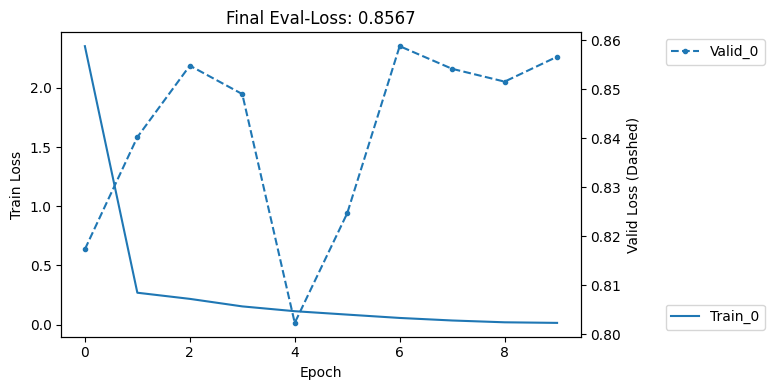

In [19]:
persuade_model_name = f"{CONFIG.MODEL_NAME}_persuade"

if not os.path.exists(os.path.join(CONFIG.OUTPUT_DIR, persuade_model_name+'.pth')):
    
    logger.info(f"Start Training on Persuade...")
    
    loss_fn = nn.MSELoss()
    eval_fn = CohenKappaRegression(weights='quadratic') #CohenKappa(weights='quadratic')
    
    essay_train, essay_test, label_train, label_test = train_test_split(
        persuade_ds['essay_id'], persuade_ds['label'], stratify=persuade_ds['label'],  test_size=0.2)
    
    persuade_train = persuade_ds.filter(lambda x: x['essay_id'] in essay_train)
    persuade_test =  persuade_ds.filter(lambda x: x['essay_id'] in essay_test)
    
    logger.info(f"Persuade Train: {len(label_train)} | Test: {len(label_test)}")
    
    persuade_train_loader = DataLoader(persuade_train, drop_last=True,  **loader_kwargs)
    persuade_test_loader = DataLoader(persuade_test, drop_last=False,  **loader_kwargs)
    
    model = DeBERTaClassifier(
        CONFIG.DEBERTA_PATH, 
        embedding_dim=CONFIG.EMBEDDING_SIZE, 
        n_classes=CONFIG.N_CLASSES,
        n_mlp_layers=0, 
        len_token=len(embedding_tokenizer)
        )

    trainer = Trainer(model, CONFIG.TRAINER_CFG, loss_fn, eval_fn, DEVICE, logger)
    
    best_weights, best_preds, loss_records = trainer.train( 
        persuade_train_loader, 
        persuade_test_loader, 
        print_epoch_freq=1, 
        from_checkpoint=None,
        use_tqdm=True
        )
        
    torch.save(best_weights, os.path.join(CONFIG.OUTPUT_DIR, persuade_model_name+'.pth'))
    
    if display_loss:
        plot_loss_record([loss_records], loss_records['valid'][-1], start_at=0, save_to=os.path.join(CONFIG.OUTPUT_DIR, f"{persuade_model_name}_loss.jpg"))
        
    del persuade_train, persuade_test, persuade_train_loader, persuade_test_loader
    torch.cuda.empty_cache()
    gc.collect()

In [20]:
train_csv['fold'] = 'train'

essay_train, essay_test, label_train, label_test = train_test_split(
    train_csv['essay_id'], train_csv['label'], stratify=train_csv['label'],  test_size=0.2)

logger.info(f"Train: {len(essay_train)}, Test: {len(essay_test)}")

train_csv.loc[essay_train.index, 'fold'] = 'train'
train_csv.loc[essay_test.index, 'fold'] = 'test'

print("Train:")
display(label_train.value_counts().sort_index() / len(label_train))

print("Test:")
display(label_test.value_counts().sort_index() / len(label_test))

Train: 13845, Test: 3462
Train:


label
0    0.072300
1    0.272878
2    0.362875
3    0.226869
4    0.056049
5    0.009029
Name: count, dtype: float64

Test:


label
0    0.072501
1    0.272964
2    0.362796
3    0.226748
4    0.056037
5    0.008954
Name: count, dtype: float64

Start Training...


Filter:   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17307 [00:00<?, ? examples/s]

Resize token embeddings...
Load weights from checkpoint: ./working/DeBerta_base_Max_1024_Persuade_Regression_persuade.pth


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 1 [0/1730] | Train Loss: 0.2519 Grad: inf LR: 4.0001e-07 | Elapse: 0.27s


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [500/1730] | Train Loss: 0.4107 Grad: 122172.2422 LR: 2.2552e-06 | Elapse: 0.29s
Epoch 1 [1000/1730] | Train Loss: 0.3982 Grad: 84924.4688 LR: 6.3783e-06 | Elapse: 0.29s
Epoch 1 [1500/1730] | Train Loss: 0.3784 Grad: 125995.5156 LR: 9.5940e-06 | Elapse: 0.29s
Epoch 1 [1729/1730] | Train Loss: 0.3776 Grad: 144541.8906 LR: 1.0000e-05 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 1 - Train Loss: 0.3776 - Valid Loss: 0.7777 - Elapsed Time: 603.52s
- Epoch 1: Best model found with loss = 0.7777.


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 2 [0/1730] | Train Loss: 0.1119 Grad: 597853.3750 LR: 1.0000e-05 | Elapse: 0.29s
Epoch 2 [500/1730] | Train Loss: 0.3192 Grad: 105841.7188 LR: 9.9745e-06 | Elapse: 0.29s
Epoch 2 [1000/1730] | Train Loss: 0.3098 Grad: 154419.0625 LR: 9.8986e-06 | Elapse: 0.29s
Epoch 2 [1500/1730] | Train Loss: 0.2822 Grad: 76318.9297 LR: 9.7730e-06 | Elapse: 0.29s
Epoch 2 [1729/1730] | Train Loss: 0.2751 Grad: 82294.0000 LR: 9.6993e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 2 - Train Loss: 0.2751 - Valid Loss: 0.8019 - Elapsed Time: 603.31s
- Epoch 2: Best model found with loss = 0.8019.


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 3 [0/1730] | Train Loss: 0.1438 Grad: 644902.6875 LR: 9.6990e-06 | Elapse: 0.29s
Epoch 3 [500/1730] | Train Loss: 0.2120 Grad: 61859.2773 LR: 9.5035e-06 | Elapse: 0.29s
Epoch 3 [1000/1730] | Train Loss: 0.1836 Grad: 66992.0859 LR: 9.2623e-06 | Elapse: 0.29s
Epoch 3 [1500/1730] | Train Loss: 0.1571 Grad: 102390.7266 LR: 8.9781e-06 | Elapse: 0.29s
Epoch 3 [1729/1730] | Train Loss: 0.1550 Grad: 275730.4062 LR: 8.8343e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 3 - Train Loss: 0.1550 - Valid Loss: 0.7800 - Elapsed Time: 602.85s


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 4 [0/1730] | Train Loss: 0.1169 Grad: inf LR: 8.8336e-06 | Elapse: 0.27s
Epoch 4 [500/1730] | Train Loss: 0.1030 Grad: 155854.1406 LR: 8.4917e-06 | Elapse: 0.29s
Epoch 4 [1000/1730] | Train Loss: 0.0991 Grad: 61145.3828 LR: 8.1144e-06 | Elapse: 0.29s
Epoch 4 [1500/1730] | Train Loss: 0.1076 Grad: 297739.9375 LR: 7.7057e-06 | Elapse: 0.29s
Epoch 4 [1729/1730] | Train Loss: 0.1137 Grad: 311748.2812 LR: 7.5091e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 4 - Train Loss: 0.1137 - Valid Loss: 0.8071 - Elapsed Time: 602.96s
- Epoch 4: Best model found with loss = 0.8071.


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 5 [0/1730] | Train Loss: 0.2567 Grad: inf LR: 7.5083e-06 | Elapse: 0.28s
Epoch 5 [500/1730] | Train Loss: 0.1138 Grad: 166500.4375 LR: 7.0611e-06 | Elapse: 0.29s
Epoch 5 [1000/1730] | Train Loss: 0.1111 Grad: 150398.5625 LR: 6.5933e-06 | Elapse: 0.29s
Epoch 5 [1500/1730] | Train Loss: 0.1047 Grad: 113628.6797 LR: 6.1094e-06 | Elapse: 0.29s
Epoch 5 [1729/1730] | Train Loss: 0.1025 Grad: 42108.3047 LR: 5.8838e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 5 - Train Loss: 0.1025 - Valid Loss: 0.8125 - Elapsed Time: 603.10s
- Epoch 5: Best model found with loss = 0.8125.


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 6 [0/1730] | Train Loss: 0.1650 Grad: 777249.6250 LR: 5.8828e-06 | Elapse: 0.29s
Epoch 6 [500/1730] | Train Loss: 0.0622 Grad: 34328.5195 LR: 5.3844e-06 | Elapse: 0.29s
Epoch 6 [1000/1730] | Train Loss: 0.0631 Grad: 96351.4922 LR: 4.8824e-06 | Elapse: 0.29s
Epoch 6 [1500/1730] | Train Loss: 0.0612 Grad: 102264.7969 LR: 4.3817e-06 | Elapse: 0.29s
Epoch 6 [1729/1730] | Train Loss: 0.0598 Grad: 35892.2812 LR: 4.1542e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 6 - Train Loss: 0.0598 - Valid Loss: 0.8017 - Elapsed Time: 602.59s


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 7 [0/1730] | Train Loss: 0.0324 Grad: 626413.1875 LR: 4.1533e-06 | Elapse: 0.29s
Epoch 7 [500/1730] | Train Loss: 0.0411 Grad: 106919.1484 LR: 3.6638e-06 | Elapse: 0.29s
Epoch 7 [1000/1730] | Train Loss: 0.0511 Grad: 59392.2070 LR: 3.1880e-06 | Elapse: 0.29s
Epoch 7 [1500/1730] | Train Loss: 0.0473 Grad: 37152.0508 LR: 2.7310e-06 | Elapse: 0.29s
Epoch 7 [1729/1730] | Train Loss: 0.0444 Grad: 70619.2969 LR: 2.5291e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 7 - Train Loss: 0.0444 - Valid Loss: 0.8069 - Elapsed Time: 603.01s


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 8 [0/1730] | Train Loss: 0.0111 Grad: 411662.2500 LR: 2.5283e-06 | Elapse: 0.29s
Epoch 8 [500/1730] | Train Loss: 0.0318 Grad: 139502.1875 LR: 2.1067e-06 | Elapse: 0.29s
Epoch 8 [1000/1730] | Train Loss: 0.0312 Grad: 118123.5312 LR: 1.7147e-06 | Elapse: 0.29s
Epoch 8 [1500/1730] | Train Loss: 0.0285 Grad: 34898.7305 LR: 1.3563e-06 | Elapse: 0.29s
Epoch 8 [1729/1730] | Train Loss: 0.0268 Grad: 52577.5938 LR: 1.2045e-06 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 8 - Train Loss: 0.0268 - Valid Loss: 0.8106 - Elapsed Time: 602.84s


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 9 [0/1730] | Train Loss: 0.0076 Grad: 331332.0625 LR: 1.2038e-06 | Elapse: 0.29s
Epoch 9 [500/1730] | Train Loss: 0.0203 Grad: 94247.7422 LR: 9.0097e-07 | Elapse: 0.29s
Epoch 9 [1000/1730] | Train Loss: 0.0158 Grad: 106142.2188 LR: 6.4002e-07 | Elapse: 0.29s
Epoch 9 [1500/1730] | Train Loss: 0.0152 Grad: 173590.0000 LR: 4.2361e-07 | Elapse: 0.29s
Epoch 9 [1729/1730] | Train Loss: 0.0143 Grad: 53563.1641 LR: 3.3999e-07 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 9 - Train Loss: 0.0143 - Valid Loss: 0.8132 - Elapsed Time: 603.07s
- Epoch 9: Best model found with loss = 0.8132.


Train:   0%|          | 0/1730 [00:00<?, ?batch/s]

Epoch 10 [0/1730] | Train Loss: 0.0058 Grad: 251400.8125 LR: 3.3964e-07 | Elapse: 0.29s
Epoch 10 [500/1730] | Train Loss: 0.0111 Grad: 96193.6016 LR: 1.9209e-07 | Elapse: 0.29s
Epoch 10 [1000/1730] | Train Loss: 0.0088 Grad: 92646.2734 LR: 9.3629e-08 | Elapse: 0.29s
Epoch 10 [1500/1730] | Train Loss: 0.0091 Grad: 110722.4531 LR: 4.5269e-08 | Elapse: 0.29s
Epoch 10 [1729/1730] | Train Loss: 0.0087 Grad: 115366.2656 LR: 4.0000e-08 | Elapse: 0.29s


Valid:   0%|          | 0/433 [00:00<?, ?batch/s]

Epoch 10 - Train Loss: 0.0087 - Valid Loss: 0.8146 - Elapsed Time: 603.25s
- Epoch 10: Best model found with loss = 0.8146.
Fold 0 | Time: 101.17min | Overall Evaluation Loss: 0.8146


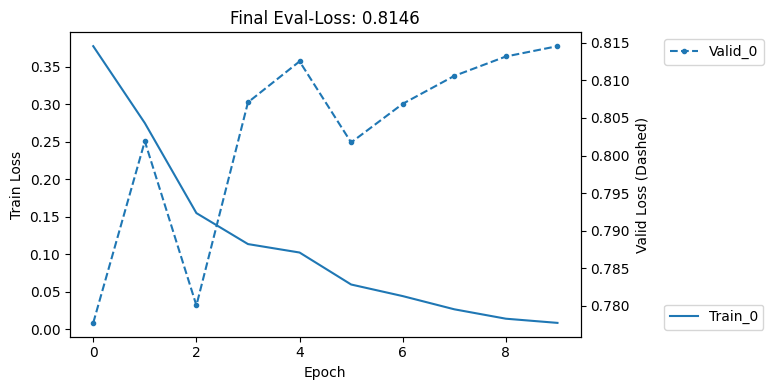

In [21]:
logger.info(f"Start Training...")

tik = time()

loss_fn = nn.MSELoss()
eval_fn = CohenKappaRegression(weights='quadratic') #CohenKappa(weights='quadratic')

train_folds = train_ds.filter(lambda x: x['essay_id'] in essay_train.tolist())
valid_folds = train_ds.filter(lambda x: x['essay_id'] in essay_test.tolist())

train_loader = DataLoader(train_folds, drop_last=True,  **loader_kwargs)
valid_loader = DataLoader(valid_folds, drop_last=False, **loader_kwargs)
        
model =  DeBERTaClassifier(
    CONFIG.DEBERTA_PATH, 
    embedding_dim=CONFIG.EMBEDDING_SIZE, 
    n_classes=CONFIG.N_CLASSES,
    n_mlp_layers=0, 
    len_token=len(embedding_tokenizer)
)
        
# trainer = Trainer(model, loss_fn, eval_fn, TRAIN_CONFIG)
trainer = Trainer(model, CONFIG.TRAINER_CFG, loss_fn, eval_fn, DEVICE, logger)
    
best_weights, best_preds, loss_records = trainer.train( 
    train_loader, 
    valid_loader, 
    print_epoch_freq=1, 
    from_checkpoint=os.path.join(CONFIG.OUTPUT_DIR, persuade_model_name+'.pth'),
    use_tqdm=True
    )

save_model_name = f"{CONFIG.MODEL_NAME}_fold_0"
torch.save(best_weights, os.path.join(CONFIG.OUTPUT_DIR, save_model_name + ".pth"))

df_test = pd.DataFrame({ 'essay_id': valid_folds['essay_id']})
df_test['true_score'] = [x['label'] for x in valid_folds]
df_test['pred_score'] = best_preds
       
del train_folds, valid_folds, train_loader, valid_loader
torch.cuda.empty_cache()
gc.collect()
        
y_true = df_test['true_score'].values
y_pred = df_test['pred_score'].values.clip(0, 5).round(0)

valid_loss = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    
if logger is not None:
    logger.info(f"Fold 0 | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss:.4f}")

if display_loss:
    plot_loss_record([loss_records], valid_loss, start_at=0, save_to=os.path.join(CONFIG.OUTPUT_DIR, f"{save_model_name}_loss.jpg"))

# Save the final oof predictions
df_test.to_csv(f"{CONFIG.OUTPUT_DIR}/{CONFIG.MODEL_NAME}_oof.csv", index=False)

,essay_id,true_score,pred_score
0,000fe60,2,1.671382
1,001ab80,3,3.502338
2,0066c7c,1,1.307669
3,006d0e1,3,3.169393
4,0079938,2,1.703763
5,007db64,1,0.623270
6,00a3575,1,0.681724
7,00b2fe2,3,2.704530
8,00b3311,3,1.703898
9,00d4911,3,2.256612


Overall Quadratic Weighted Kappa: 0.814565


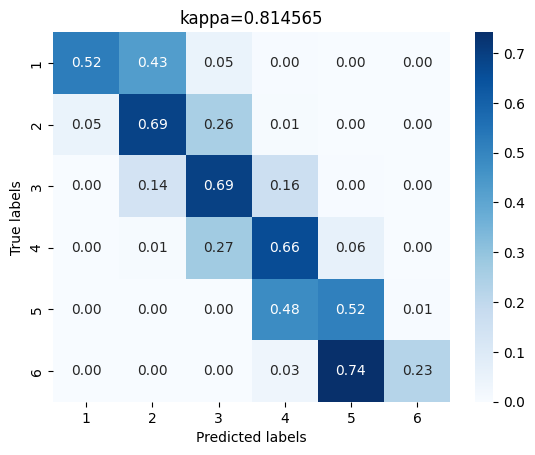

In [22]:
display(df_test.head(10))

y_true = df_test['true_score'].values
y_pred = df_test['pred_score'].values.clip(0, 5).round(0)

kappa_score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
logger.info(f"Overall Quadratic Weighted Kappa: {kappa_score:.6f}")

cm = confusion_matrix(y_true, y_pred, normalize='true')
# Plotting the normalized confusion matrix
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'kappa={kappa_score:.6f}')
fig.savefig(os.path.join(CONFIG.OUTPUT_DIR, f"{CONFIG.MODEL_NAME}_cm.jpg"))
plt.show()